# CMIP6 access and processing at DKRZ

In this notebook, we show how to access CMIP6 data at the DKRZ filesystem using the Intake catalog and xarray. To lift the heavy datasets we will process in parallel with dask using the power of the mistral supercomputer. This notebook is loosely based on the [CMIP6 global temperature pangeo example](http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/global_mean_surface_temp.html).

import all neccessary modules here:

In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm
import intake
import fsspec
import seaborn as sns
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

dask.__version__

<ipython-input-1-bed32f30e077>:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


'2021.04.0'

We use `dask.distributed` to parallelize file access and processing. This will speed up our computations...

In [2]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client



In [3]:
client = Client(n_workers=24, threads_per_worker=2)
client

Client Scheduler: tcp://127.0.0.1:37717 Dashboard: /user/g300046/advanced//proxy/8787/status,Cluster Workers: 24 Cores: 48 Memory: 248.44 GiB


If you click on the dashboard link, you will see the dask workers in action!

In [4]:
import intake
%matplotlib
url = "/work/ik1017/Catalogs/mistral-cmip6.json"
pangeo_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
cat = intake.open_esm_datastore(url)
cat

Using matplotlib backend: agg


,unique
activity_id,19
institution_id,39
source_id,101
experiment_id,210
member_id,447
table_id,38
variable_id,1162
grid_label,12
dcpp_init_year,61
version,653


The catalog is build around a pandas dataframe. We can also access it to explore the available data, e.g., 

In [5]:
cat.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path,opendap_url
0,AerChemMIP,BCC,BCC-ESM1,hist-piAer,r1i1p1f1,AERmon,c2h6,gn,NaN,v20200511,185001-201412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/AerCh...
1,AerChemMIP,BCC,BCC-ESM1,hist-piAer,r1i1p1f1,AERmon,c3h6,gn,NaN,v20200511,185001-201412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/AerCh...
2,AerChemMIP,BCC,BCC-ESM1,hist-piAer,r1i1p1f1,AERmon,c3h8,gn,NaN,v20200511,185001-201412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/AerCh...
3,AerChemMIP,BCC,BCC-ESM1,hist-piAer,r1i1p1f1,AERmon,cdnc,gn,NaN,v20200522,185001-201412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/AerCh...
4,AerChemMIP,BCC,BCC-ESM1,hist-piAer,r1i1p1f1,AERmon,ch3coch3,gn,NaN,v20200511,185001-201412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/AerCh...


The catalog is actually build around a huge dataframe (or csv file) that contains a row for each netcdf file at DKRZ's CMIP6 pool. The row contains the filename including the path (`path` column) and several other CMIP related attributes that describe the content of the file. The catalog uses this table to search and filter for data and we don't even have to know where the file is exactly located! This would be nearly impossible to do by hand as you can see that the complete `CMIP6` catalog contains more than **5 million NetCDF files!**

We can also access the table using typical pandas data exploration techniques, e.g.,

In [6]:
cat.df.activity_id.unique()

array(['AerChemMIP', 'C4MIP', 'CDRMIP', 'CFMIP', 'CMIP', 'DAMIP', 'DCPP',
       'FAFMIP', 'GMMIP', 'GeoMIP', 'HighResMIP', 'ISMIP6', 'LS3MIP',
       'LUMIP', 'OMIP', 'PAMIP', 'PMIP', 'RFMIP', 'ScenarioMIP'],
      dtype=object)

This shows all available activity ids. We only want to access data concerning the `CMIP` and `ScenarioMIP` activities. Let's reduce our search results:

In [7]:
cmip6 = cat.search(activity_id= ['CMIP', 'ScenarioMIP'])
cmip6

,unique
activity_id,2
institution_id,33
source_id,67
experiment_id,19
member_id,220
table_id,38
variable_id,1126
grid_label,11
dcpp_init_year,0
version,557


That's still a lot of data (although, we almost reduced by half). Let's check out all available experiment ids that are available:

In [8]:
cmip6.df.experiment_id.unique()

array(['1pctCO2', 'abrupt-4xCO2', 'amip', 'historical', 'piControl',
       'esm-hist', 'esm-piControl', 'ssp126', 'ssp245', 'ssp370',
       'ssp585', 'esm-piControl-spinup', 'piControl-spinup', 'hist-GHG',
       'hist-nat', 'ssp119', 'ssp434', 'ssp460', 'ssp534-over'],
      dtype=object)

Let's concentrate on the usual suspects. We will furter reduce our catalog to use only the `historical` and common `ssp` scenarios. Here, we also reduce our catalog to monthly output of the surface temperature `tas` and the `r1i1p1f1` member id.

In [9]:
expts = ['historical', 'ssp126', 'ssp245', 'ssp585']
attributes = {'variable_id' : 'tas', 'table_id' : 'Amon', 'member_id' : 'r1i1p1f1' ,'experiment_id': expts}
subset = cmip6.search(**attributes, require_all_on = 'source_id')
subset

,unique
activity_id,2
institution_id,24
source_id,30
experiment_id,4
member_id,1
table_id,1
variable_id,1
grid_label,3
dcpp_init_year,0
version,56


As you can see, we have reduced our initial search of more than 5 million files to only 1652 that are of interest to us. Let again use the pandas dataframe to explore what we got, e.g.,

In [10]:
subset.df.groupby("source_id")[
    ["experiment_id", "member_id"]
].nunique()

,experiment_id,member_id
source_id,,
ACCESS-CM2,4,1
ACCESS-ESM1-5,4,1
AWI-CM-1-1-MR,4,1
BCC-CSM2-MR,4,1
CAMS-CSM1-0,4,1
CIESM,4,1
CMCC-CM2-SR5,4,1
CMCC-ESM2,4,1
CanESM5,4,1


Ok, we have now all `tas` datasets from all CMIP6 models for the historical period and three scenario experiments filtered out. Now, it's the time to actually look at the data. Let's open the datasets using the `to_dataset_dict` function that is built into the `intake-esm` catalog:

In [13]:
dsets = subset.to_dataset_dict(cdf_kwargs = {"use_cftime": True})
#dsets = subset.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [14]:
dsets.keys()

dict_keys(['ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp245.Amon.gr', 'ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp126.Amon.gn', 'ScenarioMIP.CMCC.CMCC-ESM2.ssp126.Amon.gn', 'ScenarioMIP.AS-RCEC.TaiESM1.ssp126.Amon.gn', 'ScenarioMIP.NUIST.NESM3.ssp585.Amon.gn', 'ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp126.Amon.gr', 'ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp126.Amon.gn', 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp245.Amon.gr', 'ScenarioMIP.CAS.FGOALS-f3-L.ssp126.Amon.gr', 'ScenarioMIP.KIOST.KIOST-ESM.ssp126.Amon.gr1', 'ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp245.Amon.gn', 'CMIP.KIOST.KIOST-ESM.historical.Amon.gr1', 'ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp245.Amon.gn', 'ScenarioMIP.BCC.BCC-CSM2-MR.ssp585.Amon.gn', 'ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.Amon.gn', 'ScenarioMIP.CCCma.CanESM5.ssp245.Amon.gn', 'CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn', 'CMIP.CMCC.CMCC-CM2-SR5.historical.Amon.gn', 'CMIP.CSIRO.ACCESS-ESM1-5.historical.Amon.gn', 'ScenarioMIP.KIOST.KIOST-ESM.ssp245.Amon.gr1', 'ScenarioMIP.INM.INM-CM4-8.ssp126.Amon.gr1'

In [15]:
ds = dsets['ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp126.Amon.gr']
ds

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, lat: 143, lon: 144, member_id: 1, time: 3432)
Coordinates:
  * lat          (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    height       float64 ...
  * time         (time) object 2015-01-16 12:00:00 ... 2300-12-16 12:00:00
  * member_id    (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: axis_nbounds
Data variables:
    time_bounds  (time, axis_nbounds) object 2015-01-01 00:00:00 ... 2301-01-...
    tas          (member_id, time, lat, lon) float32 244.4 244.4 ... 264.5 264.5
Attributes: (12/50)
    description:             Future scenario with low radiative forcing by th...
    sub_experiment_id:       none
    data_specs_version:      01.00.28
    contact:                 ipsl-cmip6@listes.ipsl.fr
    parent_mip_era:          CMIP6
    parent_variant_label:    r1i1p1f1
    ...                      ...
    dr2xml_version:          1.16
    product:                 model-output
    institution:             Institut Pierre Simon Laplace, Paris 75252, France
    parent_source_id:        IPSL-CM6A-LR
    license:                 CMIP6 model data produced by IPSL is licensed un...
    intake_esm_dataset_key:  ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp126.Amon.gr

In [16]:
mean = ds.tas.groupby('time.year').mean().mean(dim=('lat', 'lon'))


In [17]:
_mean = mean.compute()

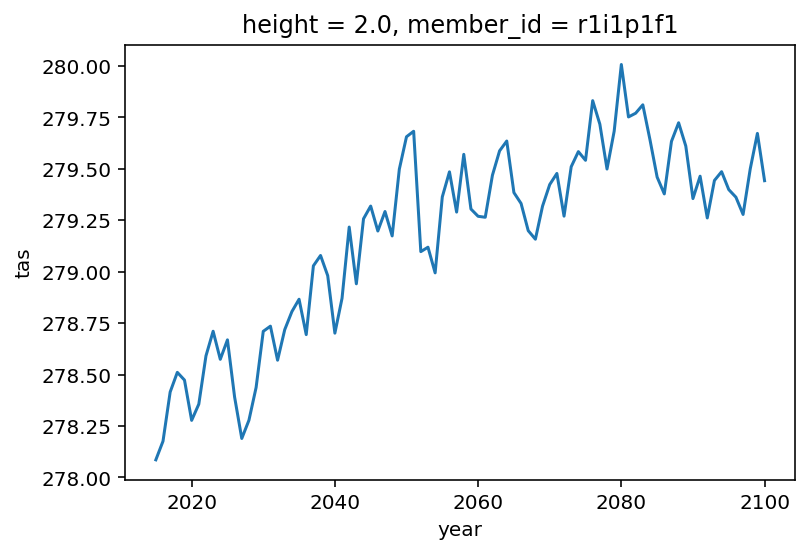

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
_mean.sel(year=slice(2015,2100)).plot()

In [19]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds
                 if (('bounds') in vname ) or ('bnds') in vname]
    return ds.drop(drop_vars)

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    return drop_all_bounds(ds).mean(dim=('lon', 'lat'))


In [20]:
expt_da = xr.DataArray(expts, dims='experiment', name='experiment',
                       coords={'experiment': expts})

In [21]:
expt_da

<xarray.DataArray 'experiment' (experiment: 4)>
array(['historical', 'ssp126', 'ssp245', 'ssp585'], dtype='<U10')
Coordinates:
  * experiment  (experiment) <U10 'historical' 'ssp126' 'ssp245' 'ssp585'

In [22]:
from collections import defaultdict
dsets_dict = defaultdict(dict)

from tqdm.autonotebook import tqdm

for key, ds in tqdm(dsets.items()):
    attrs = key.split('.')
    source_id = attrs[2]
    experiment_id = attrs[3]
    print(key)
    dsets_dict[source_id][experiment_id] = ds #.tas.groupby('time.year').mean() #.mean(dim=('lat', 'lon'))
    

  0%|          | 0/120 [00:00<?, ?it/s]

ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp245.Amon.gr
ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp126.Amon.gn
ScenarioMIP.CMCC.CMCC-ESM2.ssp126.Amon.gn
ScenarioMIP.AS-RCEC.TaiESM1.ssp126.Amon.gn
ScenarioMIP.NUIST.NESM3.ssp585.Amon.gn
ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp126.Amon.gr
ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp126.Amon.gn
ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp245.Amon.gr
ScenarioMIP.CAS.FGOALS-f3-L.ssp126.Amon.gr
ScenarioMIP.KIOST.KIOST-ESM.ssp126.Amon.gr1
ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp245.Amon.gn
CMIP.KIOST.KIOST-ESM.historical.Amon.gr1
ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp245.Amon.gn
ScenarioMIP.BCC.BCC-CSM2-MR.ssp585.Amon.gn
ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.Amon.gn
ScenarioMIP.CCCma.CanESM5.ssp245.Amon.gn
CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn
CMIP.CMCC.CMCC-CM2-SR5.historical.Amon.gn
CMIP.CSIRO.ACCESS-ESM1-5.historical.Amon.gn
ScenarioMIP.KIOST.KIOST-ESM.ssp245.Amon.gr1
ScenarioMIP.INM.INM-CM4-8.ssp126.Amon.gr1
ScenarioMIP.BCC.BCC-CSM2-MR.ssp126.Amon.gn
ScenarioMIP.KIOST.KIOST-ESM.s

In [25]:
dsets_dict['CIESM']['ssp245'].time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    height   float64 2.0
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

In [27]:
dsets_dict['ACCESS-ESM1-5']['ssp245'].time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeProlepticGregorian(2015, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(2015, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(2015, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeProlepticGregorian(2100, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(2100, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeProlepticGregorian(2100, 12, 16, 12, 0, 0, 0)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    height   float64 2.0
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

In [28]:
from cftime import datetime as dt

expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_dict.items()):
    print(k)
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds.coords['time'] = [dt(date.year, date.month, 15) for date in ds.time.values]
    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_global_mean = [v[expt].pipe(global_mean)
                      for expt in expts]

    # align everything with the 4xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_global_mean, join='outer',
                                 dim=expt_da)

  0%|          | 0/30 [00:00<?, ?it/s]

KACE-1-0-G
ACCESS-CM2
CMCC-ESM2
TaiESM1
NESM3
ACCESS-ESM1-5
IPSL-CM6A-LR
FGOALS-f3-L
KIOST-ESM
CMCC-CM2-SR5
BCC-CSM2-MR
CanESM5
INM-CM4-8
MRI-ESM2-0
INM-CM5-0
GFDL-ESM4
CIESM
MIROC6
CAMS-CSM1-0
MPI-ESM1-2-LR
FGOALS-g3
IITM-ESM
NorESM2-LM
FIO-ESM-2-0
NorESM2-MM
MPI-ESM1-2-HR
AWI-CM-1-1-MR
EC-Earth3-Veg-LR
EC-Earth3
EC-Earth3-Veg


In [29]:
dsets_aligned['MPI-ESM1-2-LR']

<xarray.Dataset>
Dimensions:        (experiment_id: 4, member_id: 1, time: 3012)
Coordinates:
  * experiment_id  (experiment_id) <U10 'historical' 'ssp126' 'ssp245' 'ssp585'
  * time           (time) object 1850-01-15 00:00:00 ... 2100-12-15 00:00:00
    height         float64 2.0
  * member_id      (member_id) <U8 'r1i1p1f1'
Data variables:
    tas            (experiment_id, member_id, time) float32 275.7 ... 282.1

In [30]:
with progress.ProgressBar():
    dsets_aligned_ = dask.compute(dsets_aligned)[0]

In [31]:
dsets_aligned_.keys()

dict_keys(['KACE-1-0-G', 'ACCESS-CM2', 'CMCC-ESM2', 'TaiESM1', 'NESM3', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'FGOALS-f3-L', 'KIOST-ESM', 'CMCC-CM2-SR5', 'BCC-CSM2-MR', 'CanESM5', 'INM-CM4-8', 'MRI-ESM2-0', 'INM-CM5-0', 'GFDL-ESM4', 'CIESM', 'MIROC6', 'CAMS-CSM1-0', 'MPI-ESM1-2-LR', 'FGOALS-g3', 'IITM-ESM', 'NorESM2-LM', 'FIO-ESM-2-0', 'NorESM2-MM', 'MPI-ESM1-2-HR', 'AWI-CM-1-1-MR', 'EC-Earth3-Veg-LR', 'EC-Earth3', 'EC-Earth3-Veg'])

In [32]:
models = list(dsets_aligned_.keys())
model_da = xr.DataArray(models, dims='model', name='model',
                         coords={'model': models})

big_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                    dim=model_da)

big_ds

<xarray.Dataset>
Dimensions:        (bnds: 2, experiment_id: 4, member_id: 1, model: 30, time: 5412)
Coordinates:
  * model          (model) <U16 'KACE-1-0-G' 'ACCESS-CM2' ... 'EC-Earth3-Veg'
  * bnds           (bnds) float64 1.0 2.0
  * time           (time) object 1850-01-15 00:00:00 ... 2300-12-15 00:00:00
  * experiment_id  (experiment_id) <U10 'historical' 'ssp126' 'ssp245' 'ssp585'
  * member_id      (member_id) <U8 'r1i1p1f1'
Data variables:
    tas            (model, experiment_id, member_id, time) float32 275.3 ... nan

In [33]:
big_ds.tas.time

<xarray.DataArray 'time' (time: 5412)>
array([cftime.datetime(1850, 1, 15, 0, 0, 0, 0, calendar='gregorian'),
       cftime.datetime(1850, 2, 15, 0, 0, 0, 0, calendar='gregorian'),
       cftime.datetime(1850, 3, 15, 0, 0, 0, 0, calendar='gregorian'), ...,
       cftime.datetime(2300, 10, 15, 0, 0, 0, 0, calendar='gregorian'),
       cftime.datetime(2300, 11, 15, 0, 0, 0, 0, calendar='gregorian'),
       cftime.datetime(2300, 12, 15, 0, 0, 0, 0, calendar='gregorian')],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-15 00:00:00 ... 2300-12-15 00:00:00

In [34]:
annual_mean = big_ds.groupby('time.year').mean()

In [35]:
annual_mean

<xarray.Dataset>
Dimensions:        (bnds: 2, experiment_id: 4, member_id: 1, model: 30, year: 451)
Coordinates:
  * model          (model) <U16 'KACE-1-0-G' 'ACCESS-CM2' ... 'EC-Earth3-Veg'
  * bnds           (bnds) float64 1.0 2.0
  * experiment_id  (experiment_id) <U10 'historical' 'ssp126' 'ssp245' 'ssp585'
  * member_id      (member_id) <U8 'r1i1p1f1'
  * year           (year) int64 1850 1851 1852 1853 1854 ... 2297 2298 2299 2300
Data variables:
    tas            (year, model, experiment_id, member_id) float32 277.2 ... nan

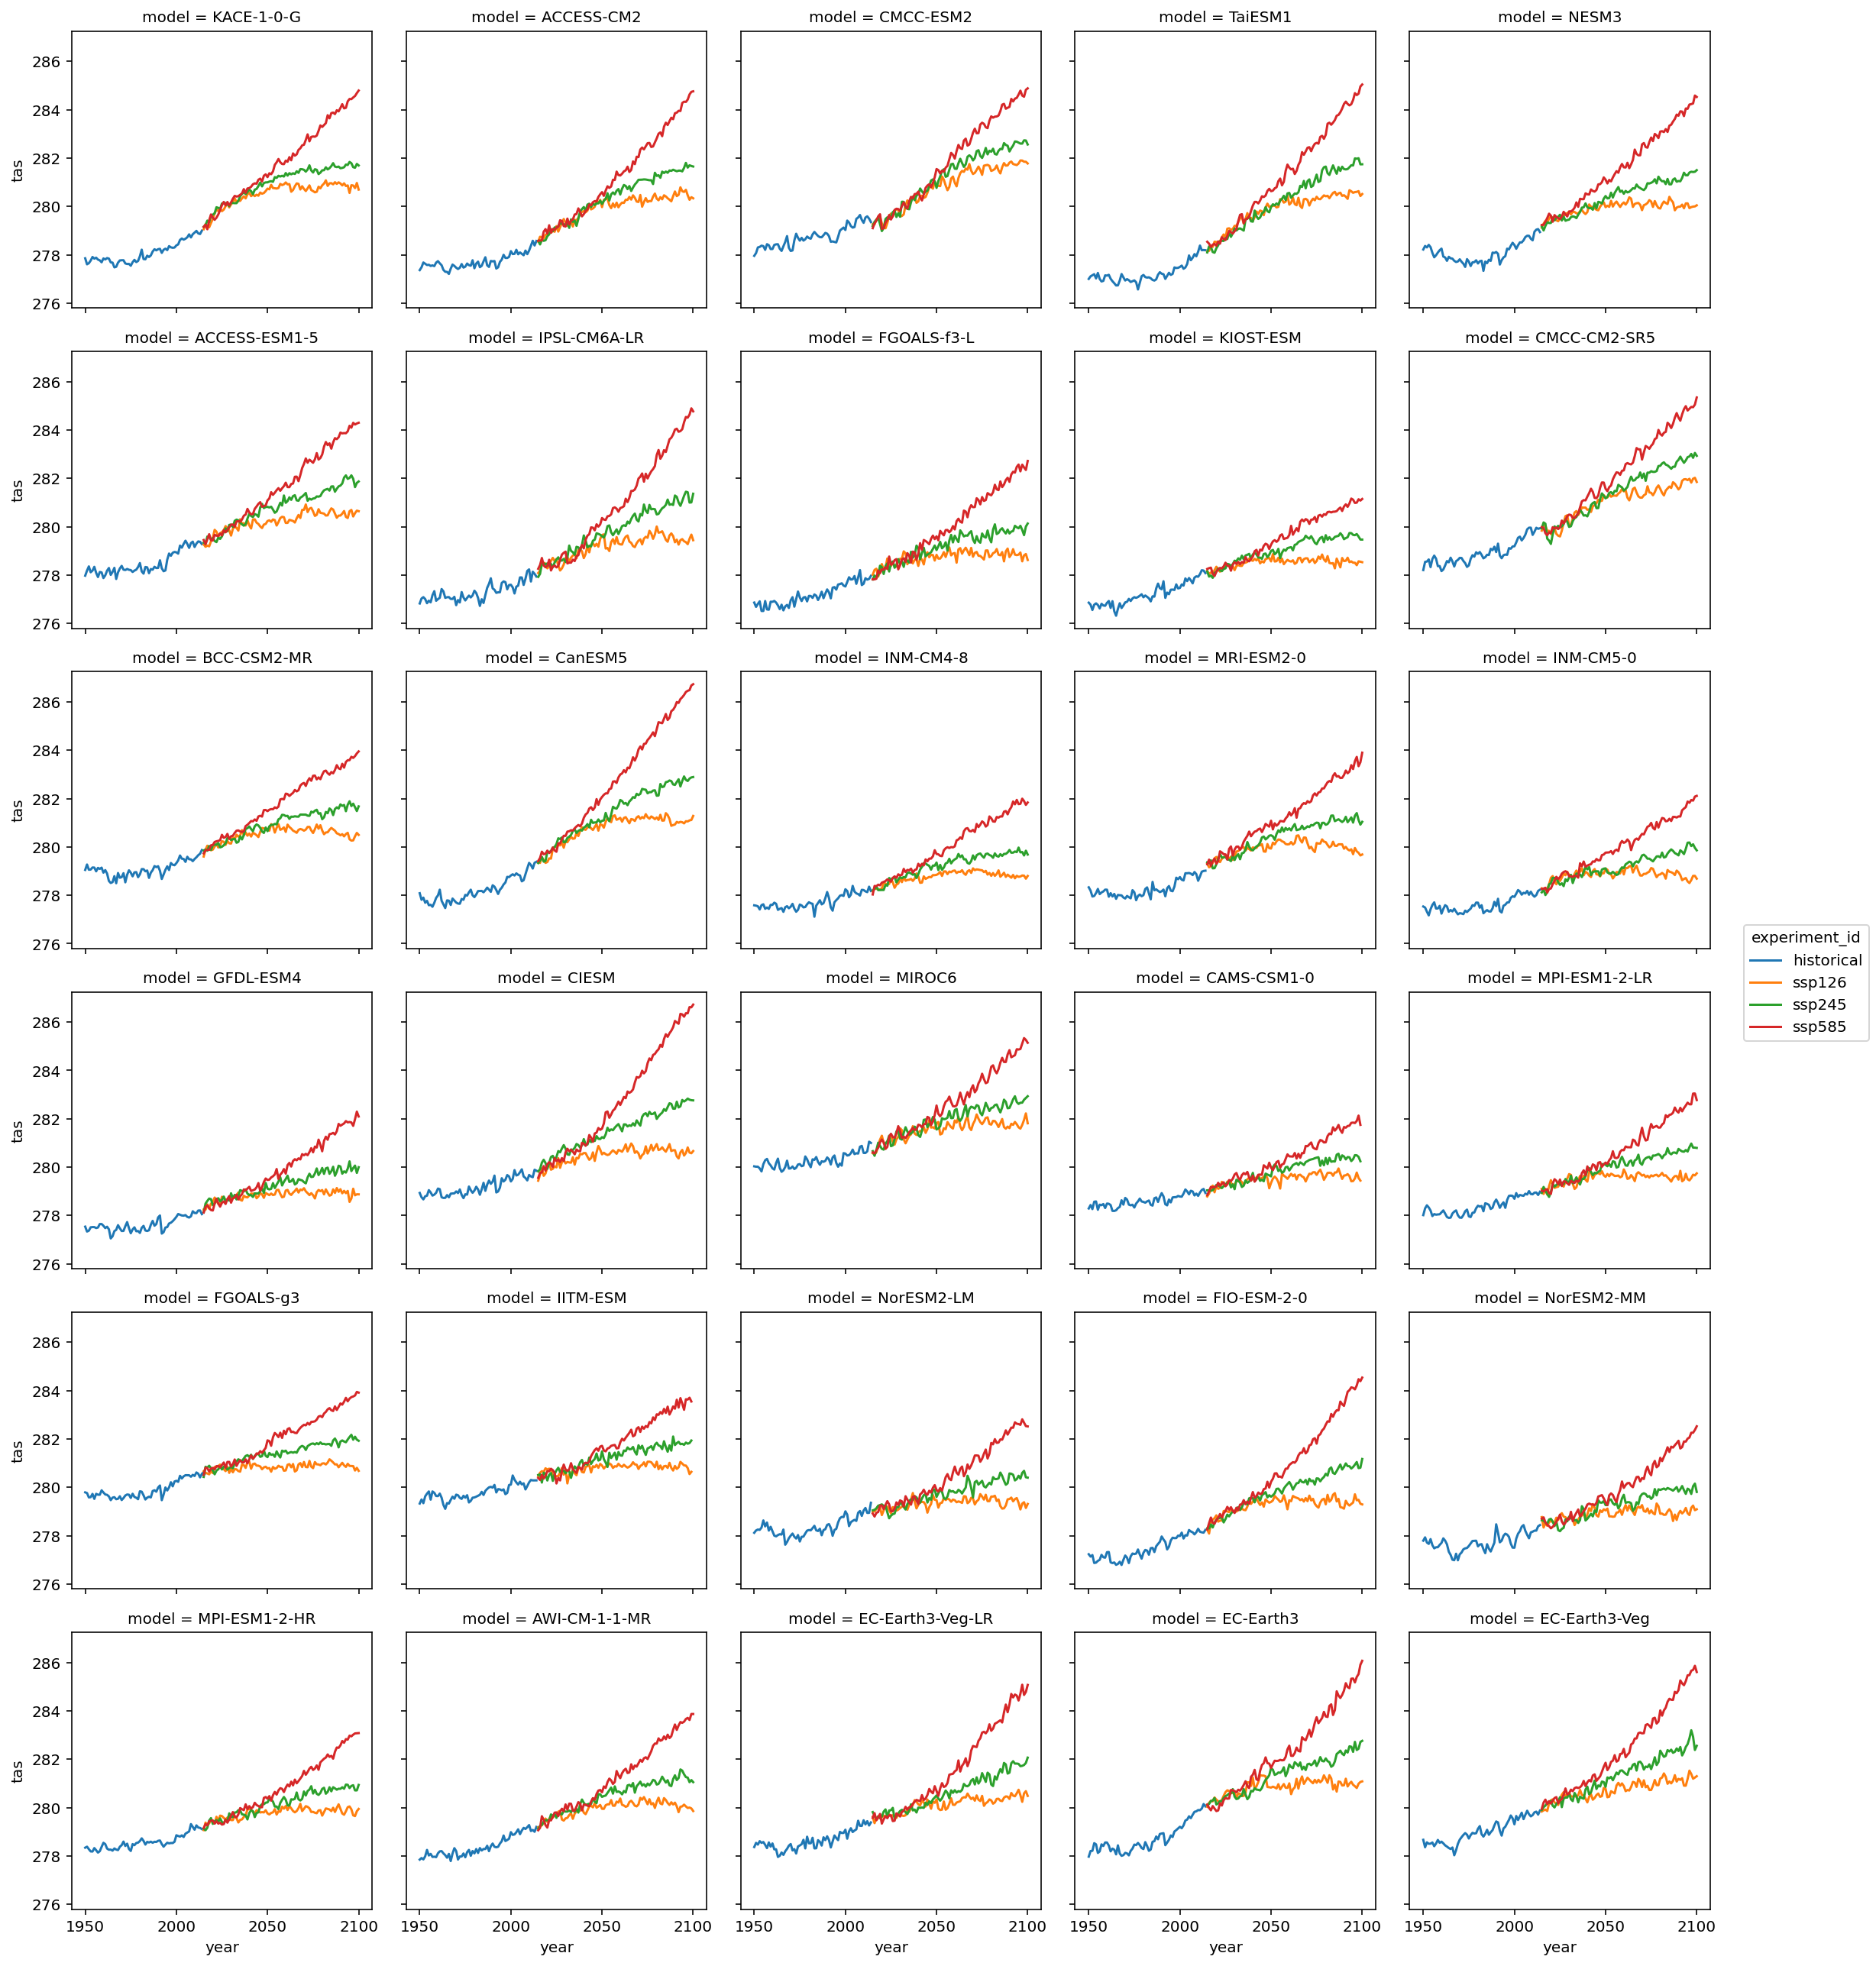

In [36]:
# create a line plot for each model id!
#import hvplot.xarray 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#annual_mean.drop('member_id')
annual_mean.tas.sel(year=slice(1950,2100)).plot(col='model', x='year', hue='experiment_id', col_wrap=5)

In [37]:
df_all = annual_mean.sel(year=slice(1950, 2100)).to_dataframe().reset_index()
df_all.head()

,bnds,experiment_id,member_id,model,year,tas
0,1.0,historical,r1i1p1f1,KACE-1-0-G,1950,277.857605
1,1.0,historical,r1i1p1f1,KACE-1-0-G,1951,277.609100
2,1.0,historical,r1i1p1f1,KACE-1-0-G,1952,277.654602
3,1.0,historical,r1i1p1f1,KACE-1-0-G,1953,277.763641
4,1.0,historical,r1i1p1f1,KACE-1-0-G,1954,277.912231


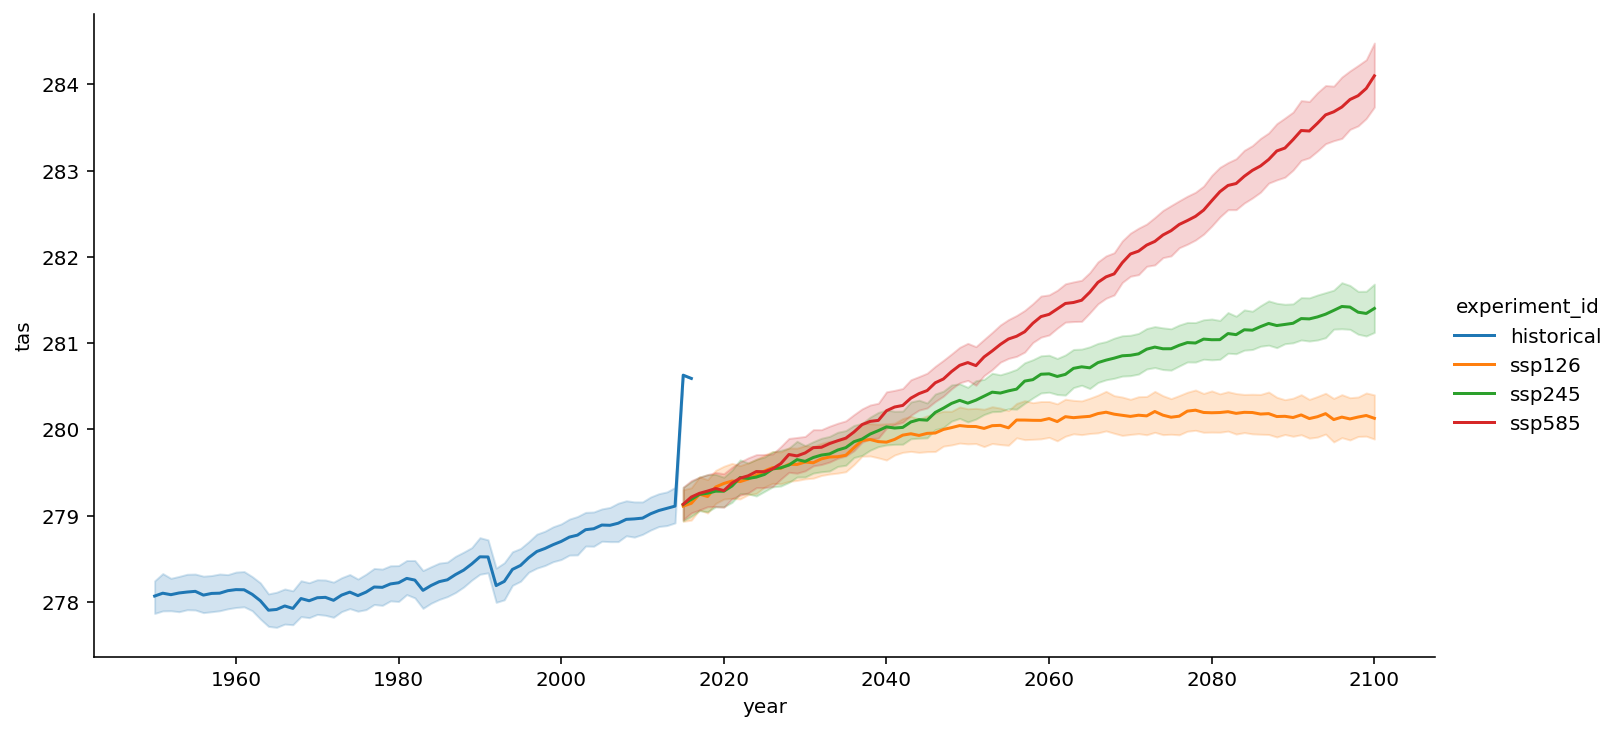

In [38]:
sns.relplot(data=df_all,
            x="year", y="tas", hue='experiment_id',
            kind="line", aspect=2);